# Projekt zaliczeniowy
<h2>Śledzenie gry w bilard</h2><br>
Kacper Dąbrowski, 151521 <br>
Jakub Kondys, 151839

## Importy i funkcje pomocnicze

In [ ]:
import cv2
import numpy as np
from PIL import Image

def show_image(image):
    if image.shape[-1] == 1:
        #grayscale
        display(Image.fromarray(image))
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(image_rgb))
def threshold(image, low=0, high=255):
    
    val_1 = cv2.threshold(image, low, 255, cv2.THRESH_BINARY)[1]
    val_2 = cv2.threshold(image, high, 255, cv2.THRESH_BINARY_INV)[1]
    return cv2.bitwise_and(val_1,val_2)

def ball_separator(image, color):
    match color.lower():
        case "red":
            sep_1 = cv2.threshold(image[:,:,1], 70, 255, cv2.THRESH_BINARY_INV)[1]
            sep_2 = cv2.threshold(image[:,:,2], 80, 255, cv2.THRESH_BINARY)[1]
            return cv2.bitwise_and(sep_1,sep_2)
        case "pink":
            sep_1 = cv2.threshold(image[:,:,0], 60, 255, cv2.THRESH_BINARY)[1]
            sep_2 = cv2.threshold(image[:,:,2], 220, 255, cv2.THRESH_BINARY)[1]
            sep_3 = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 180, 255, cv2.THRESH_BINARY)[1]
            return cv2.morphologyEx(cv2.bitwise_and(sep_1,sep_2)- sep_3, cv2.MORPH_OPEN, kernel=np.ones((3,3)))
        case "blue":
            sep_1 = cv2.threshold(image[:,:,0], 90, 255, cv2.THRESH_BINARY)[1]
            sep_2 = cv2.threshold(image[:,:,2], 23, 255, cv2.THRESH_BINARY_INV)[1]
            return cv2.bitwise_and(sep_1,sep_2)
        case "black":
            sep_1 = cv2.threshold(image[:,:,1], 80, 255, cv2.THRESH_BINARY_INV)[1]
            sep_2 = cv2.threshold(image[:,:,2], 15, 255, cv2.THRESH_BINARY_INV)[1]
            return cv2.bitwise_and(sep_1,sep_2)
        case "green": # tego sie nie da
            sep_1 = cv2.threshold(image[:,:,0], 40, 255, cv2.THRESH_BINARY)[1]
            sep_2 = threshold(image[:,:,1], 110, 158)
            sep = cv2.bitwise_and(sep_1,sep_2)
            return cv2.dilate(cv2.morphologyEx(np.clip(sep.astype(int) - ball_separator(image, "pink").astype(int) - ball_separator(image, "blue").astype(int), 0, 255).astype(np.uint8), cv2.MORPH_OPEN, kernel=np.ones((3,3))), kernel=np.ones((3,3)))
        case "yellow":
            sep_2 = threshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 150, 200)
            sep_1 = cv2.threshold(image[:,:,0], 80, 255, cv2.THRESH_BINARY)[1]
            return np.clip(sep_2.astype(int) - sep_1.astype(int), 0, 255).astype(np.uint8)
        case "white":    
            sep_1 = cv2.threshold(image[:,:,2], 230, 255, cv2.THRESH_BINARY)[1]
            sep_2 = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 210, 255, cv2.THRESH_BINARY)[1]
            sep_3 =  cv2.threshold(image[:,:,1], 254, 255, cv2.THRESH_BINARY)[1]
            return cv2.bitwise_and(cv2.bitwise_and(sep_3,sep_1),sep_2)
        case "brown":
            sep_1 = threshold(image[:,:,2], 60, 250)
            sep_2 = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 100, 255, cv2.THRESH_BINARY_INV)[1]
            sep_3 = threshold(image[:,:,1], 65, 160)
            return cv2.morphologyEx(cv2.bitwise_and(cv2.bitwise_and(sep_1,sep_2), sep_3), cv2.MORPH_OPEN, kernel=np.ones((3,3)))
        case _:
            raise ValueError

## Opis zadania

W ramach zadania należy zaproponować system śledzenia bili oraz wykrywania zdarzeń na filmie. Należało również znaleść odpowiedni materiał przedstawiający grę w bilarda z odpowiednim kątem lub zmodyfikować go do przetwarzania.

Podstawowym obiektem do przetwarzania wideo jest `cv2.VideoCapture`, dzięki któremu jesteśmy w stanie przetwarzać każdą klatkę obrazu w pętli.

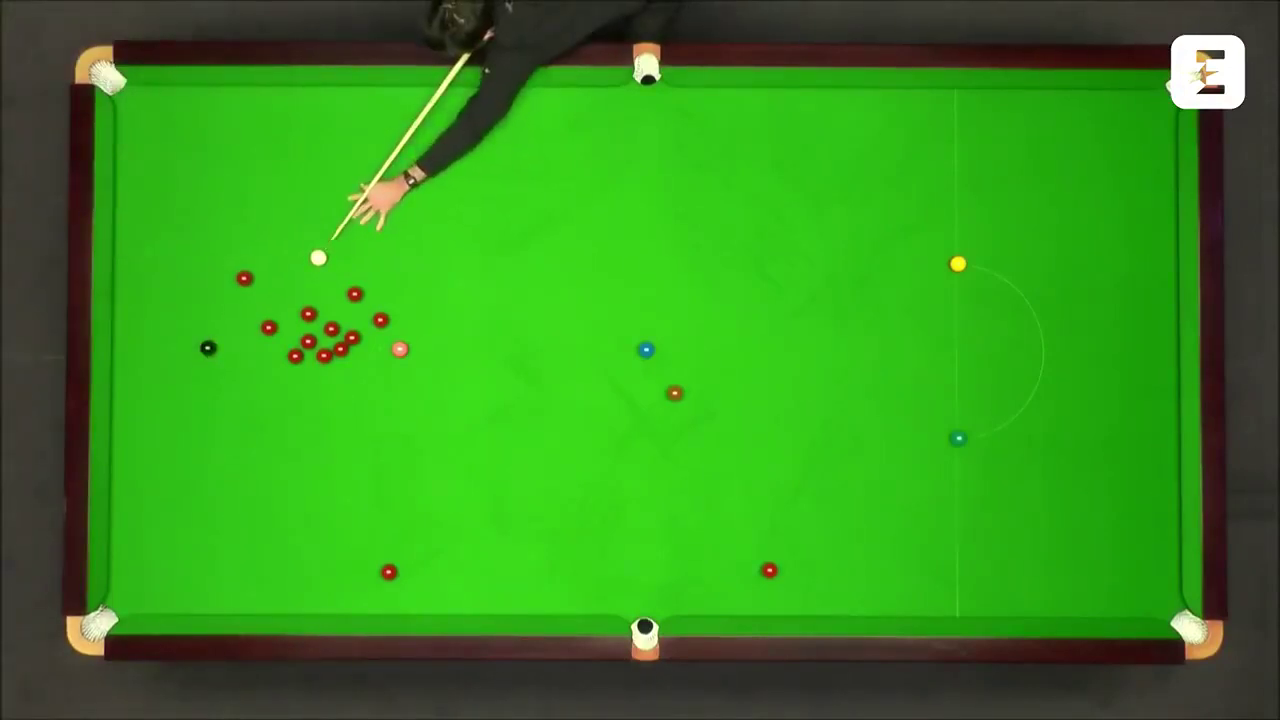

In [78]:
video = cv2.VideoCapture('video.mp4')
for i in range(200): # przewijanie filmu
    ret, frame = video.read()
show_image(frame)

## Detekcja bil
Pierwszym pomysłem, była detekcja przy użyciu `cv2.HoughCircles`, która służy typowo do wykrywanie okręgów w obrazie. Niestety efekty nie były dla nas satysfakcjonujące.

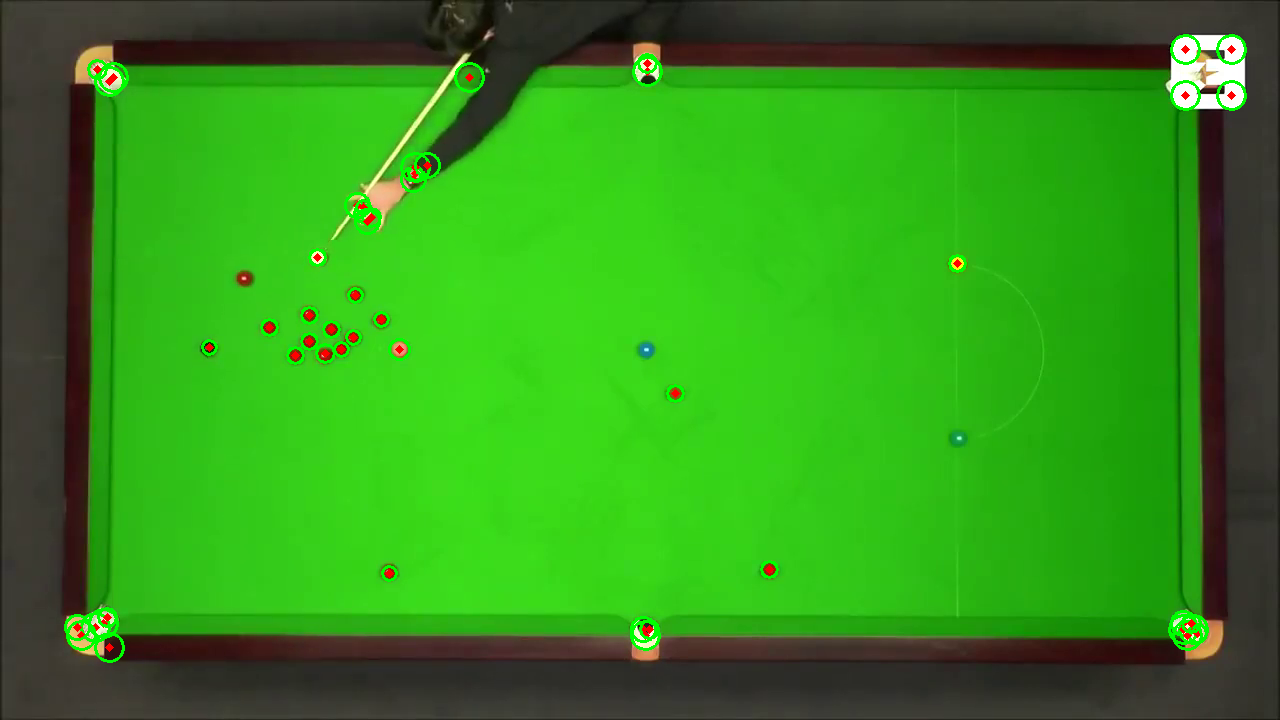

In [82]:
circles = cv2.HoughCircles(cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY), cv2.HOUGH_GRADIENT, 2, 5, param1=120, param2=30, minRadius=5, maxRadius=15)
circles = np.uint16(np.around(circles))
frame_cpy = np.copy(frame)
for i in circles[0, :]:
    cv2.circle(frame_cpy,(i[0],i[1]),i[2],(0,255,0),2)
    cv2.circle(frame_cpy,(i[0],i[1]),2,(0,0,255),3)
show_image(frame_cpy)

Występuje tutaj masa detekcji, których nie chcemy, np ręka, dołki narożniki eurosport. Separację obrazu oparliśmy na wartościach w różnych przestrzeniach barw zarówno RGB, HSV jak i skali szarości. Dobór wartości był ręczny i wymagał wielu poprawek. Główne wyzwanie stanowiło złożenie wielu masek, tak aby wyszczególnić konkretną barwę bili. Było to szczególnie trudne z uwagi na duże podobieństwo bil do siebie. Koniec końców udało nam się dojść do postaci jaką mamy. Poniżej znajduje się przykład dla brązowej bili.

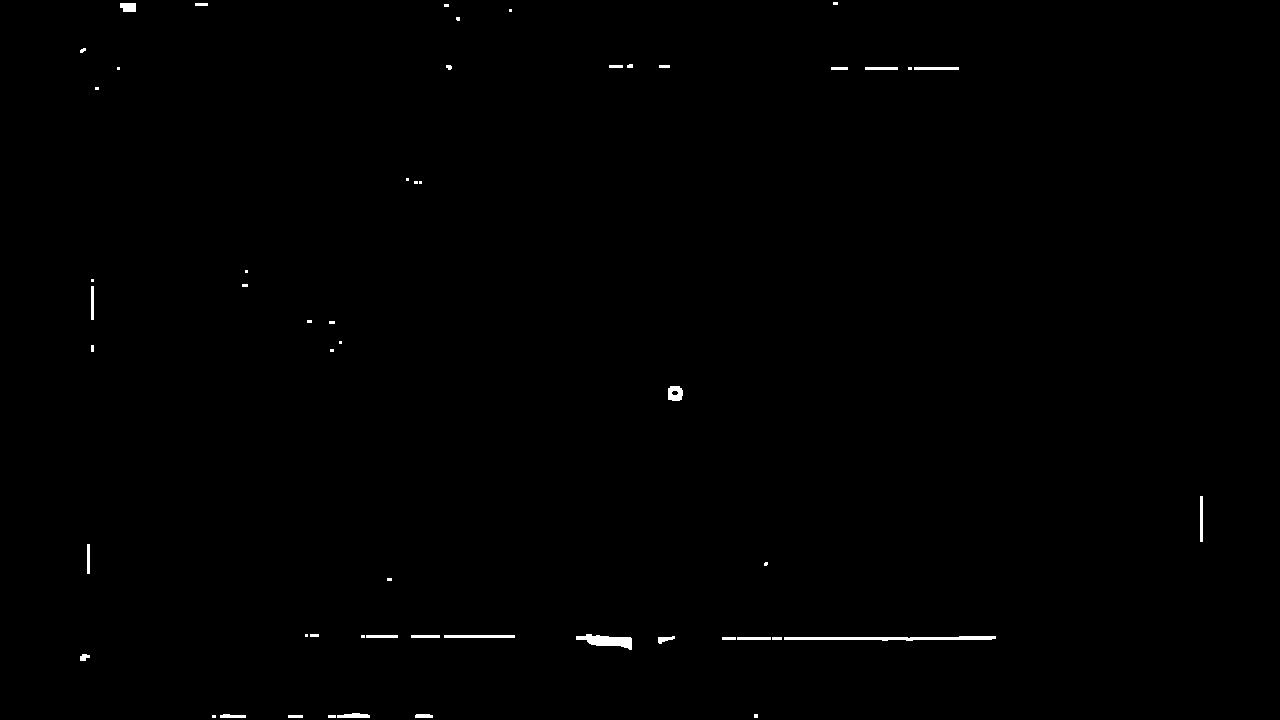

In [83]:
show_image(ball_separator(frame, "brown"))

Kontury poza polem gry są odflitrowywane. Do filtrowania konturów wykorzystaliśmy funkcję `cv2.findContours` dzięki, której jesteśmy w stanie wyszczególnić kontury z obrazu. Następnie odfiltrowane zostały kontury o polu, które nas interesuje. Kolejnym krokiem było wyznaczenie momentów na obrazie z użyciem `cv2.moments`, przy ich pomocy jesteśmy w stanie znaleźć środek ciężkości konturu, tym samym znajdując środek kuli bilardowej.
``` Python
def show_balls(frame, balls, inner_color, outher_color, low=50, high=400, show=True) -> NDArray[Any]:
    contours, _ = cv2.findContours(balls, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours: List[Any] = [c for c in contours if low < cv2.contourArea(c) < high]
    balls_coordinates: List[Any] = []
    if contours:
        for c in filtered_contours:
            M = cv2.moments(c)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"]) # wyznaczanie środka osi x
                cy = int(M["m01"] / M["m00"]) # wyznaczanie środka osi y

                if cx < 125 or cx > 1175 or cy < 95 or cy > 615: # ignorowanie obszaru poza stołem
                    continue
                if show:
                    cv2.circle(frame, (cx, cy), 15, outher_color, 1)
                    cv2.circle(frame, (cx, cy), 1, inner_color, 2)
                balls_coordinates.append([cx, cy])
        return np.array(balls_coordinates)
    return np.array([])
```
Funkcja `show_balls` zwraca współrzędne wszystkich znalezionych kul względem maski. Dodatkowo nanosi je na obraz.

Posiadając współrzędne jesteśmy w stanie śledzić wszystkie bile. Zaimplementowano specjalną funkcję, która śledzi pojedyńcze bile (czyli zgodnie z zasadami snookera: białą, czarną, niebieską, bronzową, zieloną, żółtą oraz różową)
``` Python
def track_ball(coordinates, start_coordinate, frame, color, show=False) -> tuple[List[int], bool]:
    state: bool = False
    if coordinates.shape[0] != 0:
        if show:
            print(coordinates[np.argmin(np.linalg.norm(coordinates - start_coordinate, axis=1))])
        new_coordinate = coordinates[np.argmin(np.linalg.norm(coordinates - start_coordinate, axis=1))]
        cv2.circle(frame, (new_coordinate[0], new_coordinate[1]), 15, color, 1)
        cv2.circle(frame, (new_coordinate[0], new_coordinate[1]), 1, color, 2)
        state = show_direction(frame, start_coordinate, new_coordinate, color)
        start_coordinate = new_coordinate
    return start_coordinate, state
```
Zwracane są dwie wartości `start_coordinate` - odfiltrowane współrzędne wskazujące odpowiednią bile, oraz `state` - oznaczający czy dana bila się poruszyła. Dodatkowo dla tych bil pokazywany jest kierunek ruchu z użciem `show_direction`.
``` Python
def show_direction(frame, ball_start, ball_pos, color):
    line = ball_pos - ball_start
    cv2.line(frame, ball_pos, ball_pos + line, color, 2)
    if np.linalg.norm(line) > 2:
        return True
    return False
```
Dzięki temu jesteśmy w stanie dokładnie śledzić białą bile, oraz pozostałe.

## Obsługa zdarzeń
W programie obsłużyliśmy dwa zdarzenia, wbicie czerwonej bili oraz wykrycie ruchu. Śledzenie ruchu białej bili jest na podstawie jej stanu, jeśli bila się przemieściła to rozpoczynamy detekcję ruchu. Jeśli bila wystarczająco długo się nie porusza, oznaczamy to za koniec ruchu.
``` Python
if state:
    if move:
        move = not move
        print("Ruch trwa")
else:
    steady += 1
    if steady >= 25:
        if not move:
            move = not move
            if len_red > len(red_coor): # czasami działa częściej nie
                print("Wbito czerwoną")
                score += 1
            print("Koniec ruchu")
            print(f"Aktualny wynik: {score}")
            len_red = len(red_coor)
            len_color = len(color_ball)
        steady = 0
```
Dodatkowo implementujemy tutaj wbicie czerwonej bili wraz z aktualizacją wyniku. Jeśli bila biała nie poruszyła się w przeciągu następnych 25 klatek to uznajemy, że ruch jest zakończony (25 klatek przekłada się na około sekundę). W momencie gdy wykonywany jest ruch sprawdzamy aktualizację stanu bil czerwonych. Jeśli bil czerwonych przed ruchem jest mniej niż po wykonaniu, to aktualizujemy wynik i wykrywamy wbicie czerwonej bili. Łatwo zauważyć, że w dziwny sposób aktualizowany jest licznik bil czerwonych. Zrobione to zostało w taki sposób, ponieważ czasami równo z wykryciem ruchu bili czerwonej już nie było w grze. Tym samym nie aktualizowany był wynik. Dzięki takiemu ruchowi porównujemy stan z końców kolejnych ruchów. W pierwszej klatce obrazu liczone są wszystkie bile czerwone.

Wynik końcowy znajduje się w pliku `live.py` i wymaga `utils.py` do obsługi zadania.